In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

Common functions definition

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) 

    def add(self, state, action, reward, next_state, done): 
        self.buffer.append((state, action, reward, next_state, done)) 

    def sample(self, batch_size): 
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return state, action, reward, np.array(next_state), done 

    def size(self): 
        return len(self.buffer)

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

DQN implementation

假设图像大小是210 * 160 * 3，此时一共有2 ^ (210 * 60 * 30)种状态，在计算机中存储这个数量级的值表格是不现实的。更甚者，当状态或者动作连续的时候，就有无限个状态动作对，我们更加无法使用这种表格形式来记录各个状态动作对的值。DQN 算法便可以用来解决连续状态下离散动作的问题。

In [3]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        # print('self.fc2(x).shape = ', self.fc2(x).shape)
        # torch.Size([1, 2]) in take_action
        # torch.Size([64, 2]) in update
        return self.fc2(x)

In [4]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        # actions, rewards and dones have shape of (64,)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # print('self.q_net(states).shape = ', self.q_net(states).shape) # torch.Size([64, 2])
        # 下个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)
        # print('self.target_q_net(next_states).max(1)[0]', self.target_q_net(next_states).max(1)[0].shape) 
        # torch.Size([64]) 
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = F.mse_loss(q_values, q_targets)  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [5]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(1)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                # print('state.shape', state.shape)
                # (4,)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_23685/1580198169.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 50/50 [00:21<00:00,  2.30it/s, episode=500, return=178.500]


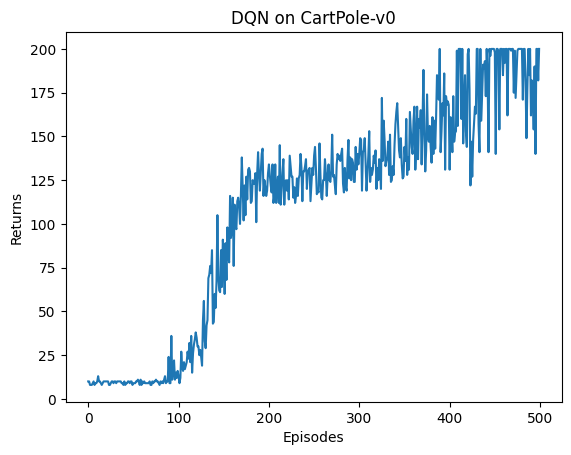

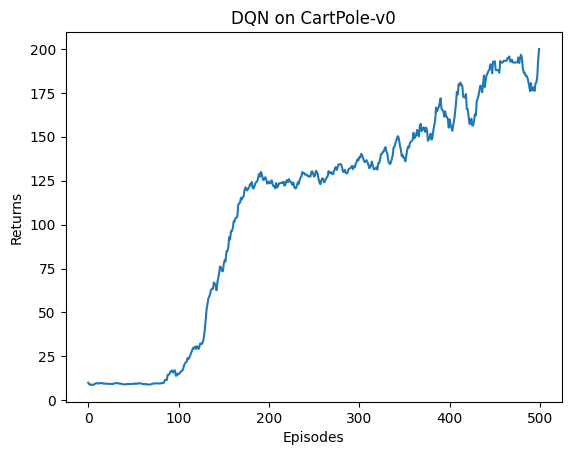

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()